# Grab USDA county-level corn data from the API

In [16]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

api_key = 'YOUR-KEY-HERE'

In [17]:
state_alphas = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
                "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
                "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
                "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
                "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

needless_info = ["CV (%)", "agg_level_desc", "asd_desc", "begin_code",
                 "class_desc", "commodity_desc", "congr_district_code",
                 "country_code", "country_name", "domain_desc",
                 "domaincat_desc", "end_code", "freq_desc", "group_desc",
                 "load_time", "location_desc", "prodn_practice_desc",
                 "reference_period_desc", "region_desc", "sector_desc",
                 "short_desc", "source_desc", "statisticcat_desc", "unit_desc",
                 "util_practice_desc", "watershed_code", "watershed_desc",
                 "week_ending", "zip_5", "county_ansi", "state_ansi"]


def get_corn(states, yields=True):
    """
    Grabs county-level corn data from USDA API.
    Input: states = list of U.S. state codes
           yields = boolean, if True return yields in bushels/acre, else return area in acres
    Output: pandas dataframe
    """
    data = pd.DataFrame()
    for state in states:
        print("Now grabbing: " + state)
        if yields:
            dat = requests.get("http://quickstats.nass.usda.gov/api/api_GET/?key=" + api_key + "&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=CORN&statisticcat_desc=YIELD&util_practice_desc=GRAIN&unit_desc=BU / ACRE&agg_level_desc=COUNTY&year__GE=1950&state_alpha=" + state)
        else:
            dat = requests.get("http://quickstats.nass.usda.gov/api/api_GET/?key=" + api_key + "&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=CORN&statisticcat_desc=AREA HARVESTED&util_practice_desc=GRAIN&unit_desc=ACRES&agg_level_desc=COUNTY&year__GE=1950&state_alpha=" + state)
        if dat.status_code == 200:
            print("Data grabbed from USDA successfully...")
            dat = dat.json()
            dat = pd.DataFrame(dat["data"])
            data = pd.concat([data, dat], ignore_index=True)
            print("Filled!")
        else:
            print("Data grabbed from USDA unsuccessfully. Error code "
                  + str(dat.status_code) + ". Skipping.")
    return data.drop(columns=needless_info)

In [18]:
# Get data
usda_county_yield = get_corn(state_alphas)
print('\n\n\n Now for the areas...\n\n\n')
usda_county_area = get_corn(state_alphas, yields=False)

Now grabbing: AL
Data grabbed from USDA successfully...
Filled!
Now grabbing: AK
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing: AZ
Data grabbed from USDA successfully...
Filled!
Now grabbing: AR
Data grabbed from USDA successfully...
Filled!
Now grabbing: CA
Data grabbed from USDA successfully...
Filled!
Now grabbing: CO
Data grabbed from USDA successfully...
Filled!
Now grabbing: CT
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing: DE
Data grabbed from USDA successfully...
Filled!
Now grabbing: FL
Data grabbed from USDA successfully...
Filled!
Now grabbing: GA
Data grabbed from USDA successfully...
Filled!
Now grabbing: HI
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing: ID
Data grabbed from USDA successfully...
Filled!
Now grabbing: IL
Data grabbed from USDA successfully...
Filled!
Now grabbing: IN
Data grabbed from USDA successfully...
Filled!
Now grabbing: IA
Data grabbed from USDA successful

In [19]:
# Get list of counties from USDA file
counties = pd.read_csv("./input/county_district_list.csv")
counties = counties.query('Use == 1.0')
counties = counties.query('District != 0')
counties = counties.query('Name != "State Total"')
counties["State"] = counties["State"].astype(str).str.zfill(2)
counties["County"] = counties["County"].astype(str).str.zfill(3)
counties["District"] = counties["District"].astype(str).str.zfill(2)
counties["GEOID"] = counties["State"] + counties["County"] + counties["District"]

# Get list of county code changes from USDA file
counties_to_change = pd.read_csv("./input/counties_old.csv")

counties_to_change["State"] = counties_to_change["State"].astype(str).str.zfill(2)
counties_to_change["County"] = counties_to_change["County"].astype(str).str.zfill(3)
counties_to_change["District"] = counties_to_change["District"].astype(str).str.zfill(2)
counties_to_change["GEOID"] = counties_to_change["State"] + counties_to_change["County"] + counties_to_change["District"]

counties_to_change["State_new"] = counties_to_change["State_new"].astype(str).str.zfill(2)
counties_to_change["County_new"] = counties_to_change["County_new"].astype(str).str.zfill(3)
counties_to_change["District_new"] = counties_to_change["District_new"].astype(str).str.zfill(2)
counties_to_change["GEOID_new"] = counties_to_change["State_new"] + counties_to_change["County_new"] + counties_to_change["District_new"]

In [20]:
# Process USDA county results
usda_county_yield["GEOID"] = usda_county_yield["state_fips_code"] + usda_county_yield["county_code"] + usda_county_yield["asd_code"]
usda_county_yield = usda_county_yield.rename(columns={"Value": "yield"})

usda_county_area["GEOID"] = usda_county_area["state_fips_code"] + usda_county_area["county_code"] + usda_county_area["asd_code"]
usda_county_area = usda_county_area.rename(columns={"Value": "area"})

# Merge into one df
usda_all = pd.merge(usda_county_yield.query("county_name != 'OTHER (COMBINED) COUNTIES'"), usda_county_area.query("county_name != 'OTHER (COMBINED) COUNTIES'"), how="outer", on=["GEOID", "state_fips_code", "county_code", "asd_code", "year", "county_name", "state_name", "state_alpha"])
usda_all["GEOID_new"] = usda_all["GEOID"]
usda_all.set_index(["GEOID"], inplace=True)

In [21]:
# Update old GEOIDs to current
for index, row in counties_to_change.iterrows():
    if row["GEOID_new"] != "0000000":
        if row["GEOID"] in usda_all.index:
            usda_all.loc[row["GEOID"],"GEOID_new"] = row["GEOID_new"]

In [22]:
# Update indexing
usda_all = usda_all.reset_index()
usda_all["GEOID"] = usda_all["GEOID_new"].str[:-2]
usda_all.drop(columns=["GEOID_new", "state_name"], inplace=True)

In [23]:
# Build index structure for final dataframe (including years)
unique_geoids = counties["GEOID"].unique()
years = np.arange(1950, 2020, 1)

all_geoids = [[unique_geoid]*len(years) for unique_geoid in unique_geoids]
all_geoids = np.ndarray.flatten(np.asarray(all_geoids))

years = [years] * len(all_geoids)
years = np.ndarray.flatten(np.asarray(years))

tuples = list(zip(*[all_geoids, years]))

index = pd.MultiIndex.from_tuples(tuples)

In [24]:
# Build empty dataframe with complete indexing
all_index = pd.DataFrame(index = index)
all_index.index.names = ["GEOID", "year"]

# Merge yields so that empty county/year pairings are "NaN"
usda_all_indexed = pd.merge(all_index, usda_all, on = ["GEOID", "year"],  how = "outer")

# Set correct indexing
usda_all_indexed = usda_all_indexed.drop_duplicates(subset=['GEOID','year']).fillna(0.0)
usda_all_indexed.set_index(["GEOID", "year"], inplace = True)
usda_all_indexed.sort_index(inplace = True)

In [25]:
# Save
usda_all_indexed['yield'] = usda_all_indexed['yield'].astype(float)
usda_all_indexed['area'] = usda_all_indexed['area'].apply(lambda x: float(x.replace(",","")) if type(x) == str else x)
usda_all_indexed.to_csv("./output/USDA_county_yields.csv")

# Fit county-level trends to USDA data

In [26]:
# Add logs
usda_all_indexed["log_yield"] = usda_all_indexed.apply(lambda x: np.log(x["yield"]) if x["yield"] > 0.0 else np.nan, axis = 1)

In [27]:
# Do quadratic fit (this throws up more than a few Polyfit warnings)
usda_all_indexed.dropna(inplace=True)
quad_index = pd.DataFrame()

for geoid in usda_all_indexed.index.unique(level = "GEOID"):

    data = usda_all_indexed.loc[geoid]
    years = data.index.to_numpy()

    z = np.polyfit(years, data['log_yield'], 2)
    p = np.poly1d(z)

    temp = pd.DataFrame(data = {"quad_fit" : pd.Series(p(years), index = pd.MultiIndex.from_arrays([[geoid]*len(years), years]))})
    temp.index.names = ["GEOID", "year"]
    
    quad_index = quad_index.append(temp)
    
usda_all_indexed = pd.merge(usda_all_indexed, quad_index, on = ["GEOID", "year"], how = "outer")

/Users/davidlafferty/anaconda3/envs/BCSD_CornYields_UQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/envs/BCSD_CornYields_UQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/envs/BCSD_CornYields_UQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/envs/BCSD_CornYields_UQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/envs/BCSD_CornYields_UQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:

In [28]:
# Get anomalies
usda_all_indexed["yield_anom"] = usda_all_indexed["log_yield"] - usda_all_indexed["quad_fit"]

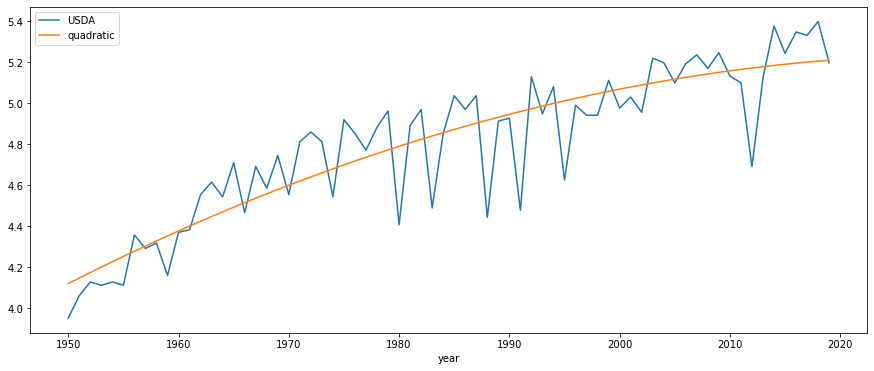

In [29]:
# Check
fig, ax = plt.subplots(figsize = (15,6))
usda_all_indexed.loc['17019'].plot(y = "log_yield", ax = ax, label = "USDA")
usda_all_indexed.loc['17019'].plot(y = "quad_fit", ax = ax, label = "quadratic")
plt.legend()
plt.show()

In [30]:
# Save
usda_all_indexed.to_csv("./output/USDA_county_yields_w_county_quad_trends.csv")